# Machine Learning Models 

In [1]:
! pip install scikit-multilearn

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [3]:
# http://www.sqlitetutorial.net/sqlite-python/create-tables/

def create_connection(db_file):

    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file) # connecting to the database 
        return conn
   
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):

    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)

    except Error as e:
        print(e)
        
def checkTableExists(dbcon):

    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type = 'table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables = table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [4]:
%%time 

database_path = '/content/drive/MyDrive/Case Studies/Stack Overflow Tag Predictor /data/Titlemoreweight.db'

if os.path.isfile(database_path):
    conn_r = create_connection(database_path) # create a connection to the database

    if conn_r is not None: # if connection is created successfully then read questions and Tags from the Table QuestionProcessed
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)

conn_r.commit()
conn_r.close()

CPU times: user 2.99 s, sys: 3.13 s, total: 6.11 s
Wall time: 1min 19s


In [24]:
preprocessed_data = preprocessed_data.head(100000)

In [25]:
# preprocessed_data = preprocessed_data.head(101)

In [26]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 100000
number of dimensions : 2


**Multi-Label Classification**

* since we already know how to solve Binary Classification and Multi-class problem using LR,SVM,DT etc
so if we can manage to convert Multi-label problem into Binary classification problem then we can leverage all the techniques to solve this problem too 


please go through the following blog for better understanding of the concept 

https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/ 

Here we won't be using Binary Relevence[OneVSrest] approach as we have around 30k unique tags(labels) instead of 4.As we might end up doing 30k classifications which can take lot of time.

* Thus sklmultilearn is very useful if we have smaller dataset.

Hence we will use second approach called classifier chains.well even in here we have to do 30k classifications but this helps whenever is one label is related to another.e.g c++ and pointers are highly related to one another so this methods more useful than the one mentioned above.

**Converting string Tags to multilable output variables** 

In [27]:
vectorizer   = CountVectorizer(tokenizer = lambda x: x.split(), binary = 'true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

# If you set binary = True then CountVectorizer no longer uses the counts of terms/tokens. If a token is present in a document,
# it is 1, if absent it is 0 regardless of its frequency of occurrence. So you will be dealing with just binary values. 
# By default, binary=False 

In [28]:
#'get_feature_name()' gives us the vocabulary.

tags = vectorizer.get_feature_names()
print(multilabel_y.shape)
print("Some of the tags we have after Tokenization and applying Vectorizer are-:\n", tags[:10])

(100000, 16321)
Some of the tags we have after Tokenization and applying Vectorizer are-:
 ['.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.each', '.emf', '.exe', '.htaccess', '.htpasswd']


<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

* Since we already know training 30k Labels is very time consuming so let's see if we can decrease the number of tags without loosing much of the information

* so we want only the subset of all the tags . let's say we have a datapoint 
x1 with labels as t1,t2,t3 and datapoint x2 with labels as t3,t4,t5 . say our subset c' has labels only {t1,t2}. then our x2 vector would be [1,1]{partial coverage}(as only t1 and t2 are present in subset t3 is missing)
On other hand our x2 will have Null vector or phie set as there is not any tag present in subset.Hence we will remove such datapoints

* Thus we can take the top tags by frequency ,as these tags would be present in most of the questions ,so if we put these most frequent tags in my subset c' I will able to generate non Null datapoints partially.Hence there would be less datapoints with NUll value.

We will sample the number of tags instead considering all of them (due to limitation of computing power) 

* https://stackoverflow.com/questions/40200070/what-does-axis-0-do-in-numpys-sum-function

In [29]:
def tags_to_choose(n): # take only 10 rows from preprocessed data to undterstand this code easily.

    # print(type(multilabel_y.sum(axis = 0) ) # returns numpy matrix , so using .tolist()

    t = multilabel_y.sum(axis = 0).tolist()[0] # summ all the columns(row-wise), will return list(list) for every column hence using [0]
    # print("t == ",t)
    # print(len(t)) # would be equal to number of columns

    sorted_tags_i = sorted(range(len(t)), key = lambda i: t[i], reverse = True) 
                   # sorting in descending order and returns the indices(column number) of the list t.
    # print("Sorted Tags == ",sorted_tags_i) # here sorted_tags_i contains the indices of tags sorted in decreasing order

    multilabel_yn = multilabel_y[:,sorted_tags_i[:n]] # extracting all the entries with value == 1 in it but only of first n columns.

    # print(type(multilabel_yn),"\n",multilabel_yn)
    # print(multilabel_yn.toarray())
    return multilabel_yn


In [30]:
a = np.array([[0, 1, 7, 0],
              [3, 0, 2, 19]])

print(a)

print(np.count_nonzero(a)) # returns #non zero values.

print(np.count_nonzero(a == 0)) # returns the #entries where value == 0.

print(np.count_nonzero(a,axis = 0)) # returns number of non zero entries along row.

print(np.count_nonzero(a,axis = 1)) # returns number of non zero entries along columns.

[[ 0  1  7  0]
 [ 3  0  2 19]]
5
3
[1 1 2 1]
[2 3]


In [31]:
def questions_explained_fn(n):
    
    
    multilabel_yn = tags_to_choose(n) # it will return scipy matrix containing only 'n' tags.

    x = multilabel_yn.sum(axis = 1) # returns total tags of each row, so X is a numpy matrix now instead of scipy sparse 

    # print("X--\n",x)
    # print("np.CountNonZero == ",(np.count_nonzero(x == 0)))  

    return (np.count_nonzero(x == 0)) # since we have already have summ of all the tags present in each row 
    
    # hence it will return all the rows which has entries == 0 .

In [32]:
%%time 

questions_explain = []

total_tags = multilabel_y.shape[1]
total_qs   = preprocessed_data.shape[0] # total number of rows are nothing but total number of questions .

print("Total Tags == ",total_tags)
print("Total Questions == ",total_qs)

for i in range(500, total_tags, 500):
  questions_explain.append( np.round(((total_qs - questions_explained_fn(i))/total_qs)*100,3) )
                               # question_explained_fn() actually returning the number of questions that were not explained

# let's say i = 3 that means n = 3 hence we will have to get the number of questions whose total sum along the top three column is non zero.

print( "total questions explained ==",questions_explain)


Total Tags ==  16321
Total Questions ==  100000
total questions explained == [92.5, 95.682, 97.073, 97.824, 98.336, 98.696, 98.945, 99.125, 99.287, 99.402, 99.481, 99.543, 99.599, 99.661, 99.712, 99.741, 99.766, 99.794, 99.813, 99.827, 99.859, 99.874, 99.882, 99.899, 99.912, 99.924, 99.936, 99.945, 99.959, 99.967, 99.979, 99.99]
CPU times: user 446 ms, sys: 0 ns, total: 446 ms
Wall time: 443 ms


In [33]:
questions_explain

[92.5,
 95.682,
 97.073,
 97.824,
 98.336,
 98.696,
 98.945,
 99.125,
 99.287,
 99.402,
 99.481,
 99.543,
 99.599,
 99.661,
 99.712,
 99.741,
 99.766,
 99.794,
 99.813,
 99.827,
 99.859,
 99.874,
 99.882,
 99.899,
 99.912,
 99.924,
 99.936,
 99.945,
 99.959,
 99.967,
 99.979,
 99.99]

In [34]:
xlabel = list(np.array(range(50,450,50))*5)

xlabel

[250, 500, 750, 1000, 1250, 1500, 1750, 2000]

In [35]:
xlabel = list(500 + np.array(range(-50,450,50))*50)

xlabel

[-2000, 500, 3000, 5500, 8000, 10500, 13000, 15500, 18000, 20500]

In [36]:
xlabel = list(500 + np.array(range(0,29587,500)))

print(xlabel)
print(questions_explain)

print(len(questions_explain),len(xlabel))

[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000]
[92.5, 95.682, 97.073, 97.824, 98.336, 98.696, 98.945, 99.125, 99.287, 99.402, 99.481, 99.543, 99.599, 99.661, 99.712, 99.741, 99.766, 99.794, 99.813, 99.827, 99.859, 99.874, 99.882, 99.899, 99.912, 99.924, 99.936, 99.945, 99.959, 99.967, 99.979, 99.99]
32 60


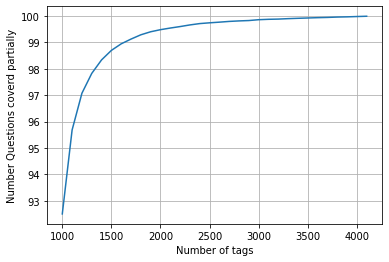

with  500 tags we are covering  92.5 % of questions


In [37]:
fig, ax = plt.subplots(1,1)

ax.plot(questions_explain)

xlabel =  list(500 + np.array(range(0,29587,500)))

ax.set_xticklabels(xlabel)

plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()

plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",500,"tags we are covering ",questions_explain[0],"% of questions")

In [38]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 7500 out of  100000


# Split the data into test and train (80:20)

In [39]:
total_size = preprocessed_data.shape[0]
train_size = int(0.80*total_size)

x_train = preprocessed_data.head(train_size)
x_test  = preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]          # selecting all columns(2000)[that are basically nothing but one hot encoded Y_label(tags)] 
y_test  = multilabel_yx[train_size:total_size,:] # selecting rest of the remaining rows

In [40]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 500)
Number of data points in test data : (20000, 500)


In [41]:
x_train.tail(2)

,question,tags
79998,abort read txt file updat matlab abort read tx...,matlab file-io concurrency locking text-files
79999,abort run mstest unit test visualstudio 2012 a...,unit-testing visual-studio-2012 mstest


In [42]:
# start = datetime.now() 
# Time taken to run this cell without using GPU: 0:05:21.570556
# vectorizer = TfidfVectorizer(min_df = 0.0009, max_features = 20000, smooth_idf = True, norm ="l2", \
                            #  tokenizer = lambda x: x.split(), sublinear_tf = False, ngram_range=(1,3))
# 
# x_train_multilabel = vectorizer.fit_transform(x_train['question'])
# x_test_multilabel = vectorizer.transform(x_test['question'])

# print("Time taken to run this cell without using GPU:", datetime.now() - start)

In [44]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df = 0.009, max_features = 700, smooth_idf = True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf = False, ngram_range=(1,3))

x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])

print("Time taken to run this cell using GPU:", datetime.now() - start)

Time taken to run this cell using GPU: 0:00:51.948921


In [45]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape) 

Dimensions of train data X: (80000, 700) Y : (80000, 500)
Dimensions of test data X: (20000, 700) Y: (20000, 500)


# Logistic Regression with OneVsRest Classifier 

In [46]:
# Time taken to run this cell : 0:02:07.149196

start = datetime.now()

classifier = OneVsRestClassifier(SGDClassifier(loss = 'log', alpha = 0.00001, penalty = 'l1'), n_jobs=-1)

classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall    = recall_score(y_test, predictions, average='micro')
f1        = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall    = recall_score(y_test, predictions, average='macro')
f1        = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.14235
Hamming loss  0.0033828
Micro-average quality numbers
Precision: 0.6815, Recall: 0.1826, F1-measure: 0.2880
Macro-average quality numbers
Precision: 0.2312, Recall: 0.0708, F1-measure: 0.0970
              precision    recall  f1-score   support

           0       0.81      0.33      0.47       820
           1       0.73      0.10      0.17      1931
           2       0.64      0.11      0.18       544
           3       0.64      0.21      0.32       222
           4       0.83      0.43      0.57      1311
           5       0.91      0.45      0.60      1014
           6       0.84      0.32      0.46      1374
           7       0.85      0.54      0.66       702
           8       0.88      0.52      0.65      1424
           9       0.86      0.08      0.14      1037
          10       0.79      0.43      0.55       797
          11       0.71      0.38      0.50       156
          12       0.71      0.28      0.40        36
          13       0.81      0.3

In [48]:
# Time taken to run this cell : 0:03:41.090821
start = datetime.now()

classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l2'), n_jobs=-1)

classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1409
Hamming loss  0.0033598
Micro-average quality numbers
Precision: 0.7423, Recall: 0.1584, F1-measure: 0.2610
Macro-average quality numbers
Precision: 0.1952, Recall: 0.0502, F1-measure: 0.0729
              precision    recall  f1-score   support

           0       0.83      0.33      0.47       820
           1       0.73      0.10      0.17      1931
           2       0.66      0.10      0.18       544
           3       0.62      0.21      0.31       222
           4       0.84      0.41      0.55      1311
           5       0.92      0.42      0.58      1014
           6       0.85      0.30      0.45      1374
           7       0.87      0.52      0.65       702
           8       0.91      0.46      0.61      1424
           9       0.88      0.07      0.13      1037
          10       0.81      0.38      0.51       797
          11       0.71      0.37      0.49       156
          12       0.71      0.28      0.40        36
          13       0.83      0.31